# DS3 Proj Step 2 - Noising architecture (Injection Net & Randamized Net & VGG Net)

# Imports and data preprocess

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.nn import init

import os
import ssl

from datetime import datetime
from random import random,randint
import math


In [2]:
incolab = False

# Colab Environnement

In [3]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
incolab = True

Mounted at /content/drive


# Retrieve the Cifar data

In [4]:
#Normalization and conversion to Tensors train and test sets

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)

#DataLoaders we are using in our algorithms
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Definition of Networks architecture

In [5]:
class Net(nn.Module):

    model_file="models/main.pth"
  
    def __init__(self):
        super().__init__()

    def save(self, name='main',incolab=False,download=False):
        '''Helper function, use it to save the model weights after training.'''
        now = datetime.now()
        prefix = '' if incolab else './models/'
        path = f'{prefix}{now.strftime("%m-%d_%H:%M")}_{name}.pth'
        torch.save(self.state_dict(), path)
        if download :
          files.download(path)


    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

    def load_for_testing(self, project_dir='./'):

        self.load(os.path.join(project_dir, Net.model_file))

In [6]:
# BasicNet

class BasicNet(Net):

    def __init__(self):
        super().__init__()
  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


In [7]:
# ResNet

class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


#definition of gaussian Noise
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize
    """

    def __init__(self, sigma=0.03, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if not self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 


class ResNet(Net):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.noise(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])



class ResNetWider(Net):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetWider, self).__init__()
        self.in_planes = 80

        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 80, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(80)
        self.layer1 = self._make_layer(block, 80, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 160, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 320, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 640, num_blocks[3], stride=2)
        self.linear = nn.Linear(640*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.noise(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetWider18():
    return ResNetWider(BasicBlock, [2,2,2,2])


NoiseNet

In [8]:
class noise_Linear(nn.Linear):

    def __init__(self, in_features, out_features, bias=True, pni='layerwise', w_noise=True):
        super(noise_Linear, self).__init__(in_features, out_features, bias)
        
        self.pni = pni
        if self.pni is 'layerwise':
            self.alpha_w = nn.Parameter(torch.Tensor([0.25]), requires_grad = True)
        elif self.pni is 'channelwise':
            self.alpha_w = nn.Parameter(torch.ones(self.out_features).view(-1,1)*0.25,
                                        requires_grad=True)
        elif self.pni is 'elementwise':
            self.alpha_w = nn.Parameter(torch.ones(self.weight.size())*0.25, requires_grad = True)
        
        self.w_noise = w_noise

    def forward(self, input):
        
        with torch.no_grad():
            std = self.weight.std().item()
            noise = self.weight.clone().normal_(0,std)

        noise_weight = self.weight + self.alpha_w * noise * self.w_noise
        output = F.linear(input, noise_weight, self.bias)
        
        return output 



class noise_Conv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1,
                 groups=1, bias=True, pni='layerwise', w_noise=True):
        super(noise_Conv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                         padding, dilation, groups, bias)

        self.pni = pni
        if self.pni is 'layerwise':
            self.alpha_w = nn.Parameter(torch.Tensor([0.25]), requires_grad = True)
        elif self.pni is 'channelwise':
            self.alpha_w = nn.Parameter(torch.ones(self.out_channels).view(-1,1,1,1)*0.25,
                                        requires_grad = True)     
        elif self.pni is 'elementwise':
            self.alpha_w = nn.Parameter(torch.ones(self.weight.size())*0.25, requires_grad = True)  
        
        self.w_noise = w_noise    


    def forward(self, input):

        with torch.no_grad():
            std = self.weight.std().item()
            noise = self.weight.clone().normal_(0,std)

        noise_weight = self.weight + self.alpha_w * noise * self.w_noise
        output = F.conv2d(input, noise_weight, self.bias, self.stride, self.padding, self.dilation,
                        self.groups)

        return output
    
class Downsampling(nn.Module):

    def __init__(self, nIn, nOut, stride):
      super(Downsampling, self).__init__()
      assert stride == 2
      self.avg = nn.AvgPool2d(kernel_size=1, stride=stride)

    def forward(self, x):
      x = self.avg(x)
      return torch.cat((x, x.mul(0)), 1)

# le resnet classique
class ResNetBasicblock(nn.Module):
  expansion = 1
  """
  ResNet basicblock 
  """
  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(ResNetBasicblock, self).__init__()

    self.conv_a = noise_Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn_a = nn.BatchNorm2d(planes)

    self.conv_b = noise_Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_b = nn.BatchNorm2d(planes)

    self.downsample = downsample

  def forward(self, x):
    residual = x

    basicblock = self.conv_a(x)
    basicblock = self.bn_a(basicblock)
    basicblock = F.relu(basicblock, inplace=True)

    basicblock = self.conv_b(basicblock)
    basicblock = self.bn_b(basicblock)

    if self.downsample is not None:
      residual = self.downsample(x)
    
    return F.relu(residual + basicblock, inplace=True)

class Reference_ResNet(Net):
  """
  ResNet optimized for the Cifar dataset
  """
  def __init__(self, block, depth, num_classes):
    """ Constructor
    Args:
      depth: number of layers.
      num_classes: number of classes
      base_width: base width
    """
    super(Reference_ResNet, self).__init__()

    #Model type specifies number of layers for CIFAR
    assert (depth - 2) % 6 == 0, 'depth should be one of 20, 32, 44, 56, 110'
    layer_blocks = (depth - 2) // 6
    print ('Reference_ResNet : Depth : {} , Layers for each block : {}'.format(depth, layer_blocks))

    self.num_classes = num_classes

    self.conv_1_3x3 = noise_Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_1 = nn.BatchNorm2d(16)

    self.inplanes = 16
    self.stage_1 = self._make_layer(block, 16, layer_blocks, 1)
    self.stage_2 = self._make_layer(block, 32, layer_blocks, 2)
    self.stage_3 = self._make_layer(block, 64, layer_blocks, 2)
    self.avgpool = nn.AvgPool2d(8)
    self.classifier = noise_Linear(64*block.expansion, num_classes)

    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        #m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight)
        m.bias.data.zero_()

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = Downsampling(self.inplanes, planes * block.expansion, stride)

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv_1_3x3(x)
    x = F.relu(self.bn_1(x), inplace=True)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    return self.classifier(x)

def NoiseResnet20(num_classes=10):
  model = Reference_ResNet(ResNetBasicblock, 20, num_classes)
  return model

def NoiseResnet32(num_classes=10):
  model = Reference_ResNet(ResNetBasicblock, 32, num_classes)
  return model

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:38: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:40: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-9c87a5e586b8>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.pni is 'layerwise':
<ipython-input-8-9c87a5e586b8>:9: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.pni is 'channelwise':
<ipython-input-8-9

In [9]:
#VGGNet

class VGG_net(Net):
    '''
    VGG net model - big architecture model
    '''
    def __init__(self, features):
        super(VGG_net, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


#Instanciation of a first VGG version
def VGGNet11():
    """VGG 19-layer model with batch normalization"""
    return VGG_net(make_layers(cfg['A'], batch_norm=True))

In [10]:
# BasicNet with Noise

class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if not self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

class BasicNetNoise(Net):

    def __init__(self):
        super().__init__()
  
    def __init__(self):
        super().__init__()
        self.noise = GaussianNoise()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.noise(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Attacks definition recall

In [11]:
class Attack():

  def __init__(self, model): 
      self.model = model 

  def visualize_attack(self, trainloader, all_epsilon, alpha=None):
      #Select random image
      dataiter = iter(trainloader)
      data, targets = dataiter.next()
      
      #Begin plot construction
      #plt.figure(figsize=(25,2))
      #plt.subplot(191, title='normal')
      #imshow(data[0])
      
      #Attacks for each epsilon
      for i, epsilon in enumerate(all_epsilon):
          plt.subplot(192+i, title='espilon %.4f:' %epsilon)
          model_copy = self.model
          model_copy.eval()
          self.model = model_copy
          perturbated_imgs = self.perturb(data, targets, epsilon, alpha=alpha)
          the_attack = perturbated_imgs[0]
          imshow(the_attack)
      
      plt.show()

In [12]:
class PGDinf_attack(Attack):

    def __init__(self, model):
        super().__init__(model)

    def perturb(self, x_natural, y, epsilon, alpha, visu=False):
        
        #Initial Predictions|
        x = x_natural.detach()
        outputs = self.model(x)
        init_pred = outputs.max(1, keepdim=True)[1]

        #Random start
        x = x + torch.zeros_like(x).uniform_(-epsilon, epsilon)
        x = torch.clamp(x, 0, 1)
        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Compute perturbations
        for i in range(10):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x],
                                       retain_graph=False, create_graph=False)[0]
            x = x.detach() + alpha * torch.sign(grad.detach())
            x = torch.min(torch.max(x, x_natural - epsilon), x_natural + epsilon)
            x = torch.clamp(x, 0, 1)
        
        #Check predictions
        final_outputs = self.model(x)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")
        return x

In [13]:
class FGSM_attack(Attack):
    
    def __init__(self, model):
        super().__init__(model)

    def perturb(self, data, targets, epsilon=1e-3, alpha=None, visu=False):
        
        #Initial prediction 
        inputs = data.detach().clone()
        outputs = self.model(inputs)
        init_pred = outputs.max(1, keepdim=True)[1]
        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Attack + new prediction 
        self.model.zero_grad()
        inputs.requires_grad = True
        with torch.enable_grad():
            outputs = self.model(inputs)
            loss = F.nll_loss(outputs, targets)
            
        grad = torch.autograd.grad(loss, [inputs])[0] 
        perturbated_img = data.detach() + epsilon * grad.sign()
        perturbated_img = torch.clamp(perturbated_img, 0, 1) 

        #Check predictions
        final_outputs = self.model(perturbated_img)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")

        return perturbated_img #, init_pred.item(), new_pred.item()
    

In [14]:
class PGDl2_attack(Attack):

    def __init__(self, model):
        super().__init__(model)

    def perturb(self, x_natural, y, epsilon, alpha, visu=False):
        
        # scale params by by 30 for comparison purpose

        epsilon *= 30
        alpha *= 30
        
        #Initial Predictions

        x = x_natural.detach()
        batch_size = len(x)
        outputs = self.model(x)
        init_pred = outputs.max(1, keepdim=True)[1]

        # Random start

        delta = torch.empty_like(x).normal_()
        d_flat = delta.view(x.size(0),-1)
        n = d_flat.norm(p=2,dim=1).view(x.size(0),1,1,1)
        r = torch.zeros_like(n).uniform_(0, 1)
        delta *= r/n*epsilon

        if visu :
            print(f"Original prediction : {init_pred[0].item()}")
        
        #Compute perturbations
        for i in range(10):
            x.requires_grad_()
            with torch.enable_grad():
                logits = self.model(x)
                loss = F.cross_entropy(logits, y)
            grad = torch.autograd.grad(loss, [x],
                                       retain_graph=False, create_graph=False)[0]
            grad_norms = torch.linalg.norm(grad.view(batch_size, -1), dim=1) + 1e-10 
            grad = grad / grad_norms.view(batch_size, 1, 1, 1) 
            x_adv = x.detach() + alpha * grad

            delta = x_adv - x
            delta_norms = torch.linalg.norm(delta.view(batch_size, -1), dim=1)
            factor = epsilon / delta_norms
            # factor = torch.min(factor, torch.ones_like(delta_norms)) # Seem to limit heavily the perturbation
            delta = delta * factor.view(-1, 1, 1, 1)

            x_adv = torch.clamp(x + delta, 0, 1).detach()

        
        #Check predictions
        final_outputs = self.model(x_adv)
        final_pred = final_outputs.max(1, keepdim=True)[1]
        if visu and init_pred[0] != final_pred[0]:
                print(f"New prediction : {final_pred[0].item()}")
        return x_adv

# Train test save utility functions

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def adjustement_learning_rate(optimizer, epoch, learning_rate, threshold1, threshold2):
    if epoch == threshold1 or epoch == threshold2:
        lr = learning_rate
        lr /= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

In [16]:
def plot_history(history,incolab = False, download=False):

    now = datetime.now()

    k = np.linspace(1,epochs,epochs)
    acc = list(history.keys())
    colors = iter(cm.rainbow(np.linspace(0, 1, len(acc))))
    plt.figure(figsize=(10, 5))

    for e in acc :
        color = next(colors)
        plt.plot(k, history[e], label=f'{e} accuracy',color=color)

    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy rate')
    plt.title("Learning curve", fontsize=16)
    plt.legend(loc="lower right")
    
    prefix = '' if incolab else './figures/'
    f_name = f'{prefix}{now.strftime("%m-%d_%H:%M")}_adv_learning_curve.jpg'
    plt.savefig(f_name)
    if download:
      files.download(f_name)

    plt.show()
    
def save_history(history,incolab = False, download=False):
    
    now = datetime.now()
    
    prefix = '' if incolab else './histories/'
    path = f'{prefix}{now.strftime("%m-%d_%H:%M")}_adv_history.csv'

    df = pd.DataFrame(history)
    df.to_csv(path,index=False)
    if download:
      files.download(path)

In [17]:
def train(model, defense, train_loader, criterion, optimizer, epsilon, alpha=None):
  
  model.train()
  train_loss = 0
  correct = 0
  total = 0

  for batch_idx, (inputs, targets) in enumerate(train_loader):
      
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()

      mix1= 0.95
      
      if defense == 'manual':
        r = random()
        if r <= mix1:
            perturbated_imgs = PGDinf_attack(model).perturb(inputs, targets, epsilon, alpha=alpha)
            outputs = model(perturbated_imgs)

        else:
            outputs = model(inputs)
      
      elif type(defense) is list :
            d = randint(0, len(defense)-1)
            perturbated_imgs = defense[d](model).perturb(inputs, targets, epsilon, alpha=alpha) 
            outputs = model(perturbated_imgs)
      
      elif defense is not None :
            perturbated_imgs = defense(model).perturb(inputs, targets, epsilon, alpha=alpha)  
            outputs = model(perturbated_imgs)

      else:
          outputs = model(inputs)

      loss = criterion(outputs, targets)
      loss.backward()

      optimizer.step()
      train_loss+=loss.item()
      _, predicted = outputs.max(1) 

      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

  train_acc = 100. * correct / total
  print('\nFinal normal ongoing training accuracy :', train_acc)

  return train_acc

def test(model, attack, test_loader, criterion, epsilon, alpha=None,verbose=True):
    model.eval()
    normal_loss = 0
    adv_loss = 0
    normal_correct = 0
    adv_correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            normal_loss += loss.item()

            # Natural accuracy

            _, predicted = outputs.max(1)
            normal_correct += predicted.eq(targets).sum().item()

            # Adversarial accuracy

            perturbated_img = attack(model).perturb(inputs, targets, epsilon, alpha=alpha)
            perturbated_outputs = model(perturbated_img)
            loss = criterion(perturbated_outputs, targets)
            adv_loss += loss.item()

            _, predicted = perturbated_outputs.max(1)
            adv_correct += predicted.eq(targets).sum().item()

            test_acc = 100. * normal_correct / total
            test_adv_acc = 100. * adv_correct / total
    
    if verbose:
      print('Final normal test accuracy:', test_acc)
      print('Final adversarial test Accuracy:', test_adv_acc)

    return test_acc, test_adv_acc
    

In [18]:
def train_test_save(model, epochs, train_loader, test_loader, criterion, optimizer, epsilon, 
          alpha=None, attack = PGDinf_attack, defense = None, lrthreshold1=15, lrthreshold2=25):

    history = {'train':[], 'test':[], 'test_adv':[]}
    
    for epoch in range(epochs):

        #Train
        
        print('\n[ Train epoch: %d ]' % (epoch+1))

        adjustement_learning_rate(optimizer, epoch,learning_rate,lrthreshold1, lrthreshold2) 
        train_acc = train(model, defense, train_loader, criterion, optimizer, epsilon, alpha)
        history["train"].append(train_acc)

        #Test

        test_acc, test_adv_acc = test(model, attack, testloader, criterion, epsilon, alpha)
        history['test'].append(test_acc)
        history['test_adv'].append(test_adv_acc)

        #Save
        
        if epoch % 5 == 0:
            model_type = 'adv' if defense is not None else 'naive'

            model.module.save(name=f'{model_type}_{str(epoch)}',incolab=incolab)
            save_history(history,incolab=incolab)
    
    return history,model

# Main training function

In [19]:
def get_trained_network (network,epochs,epsilon, learning_rate,train_loader = trainloader, test_loader = testloader,alpha=None,attack = PGDinf_attack, defense = None,load=False,lrthreshold1=100, lrthreshold2=150):

  My_net = network().to(device)
  My_net = torch.nn.DataParallel(My_net)
  cudnn.benchmark = True

  adv = attack(My_net)
  CE_loss = nn.CrossEntropyLoss()

  #SGD optimizer choosen with accelerating momentum
  sgd_optimizer = optim.SGD(My_net.parameters(), lr=learning_rate, momentum=0.9,weight_decay=0.0002)

  # Load the path of our project
  path= '/content/drive/My Drive/work/Projet 3 DS/' if incolab else './'

  if load :
    try :
      My_net.module.load_for_testing(project_dir=path) 
    except :
      print('failed')
      pass

  history, trained_model = train_test_save(My_net, epochs, train_loader, test_loader, CE_loss, sgd_optimizer, epsilon, 
          alpha, attack, defense,lrthreshold1=lrthreshold1, lrthreshold2=lrthreshold2)

  return history,trained_model

In [20]:
# Hyperparams

epochs= 50
learning_rate = 0.1
epsilon = 0.03
alpha = 0.0075

# Basic net

In [ ]:
# PGDinf
history,basicnet_adv_pgdinf = get_trained_network(BasicNet,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=60, lrthreshold2=80)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 13.446
Final normal test accuracy: 23.77
Final adversarial test Accuracy: 19.12

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 18.514
Final normal test accuracy: 28.49
Final adversarial test Accuracy: 22.34

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 19.922
Final normal test accuracy: 28.23
Final adversarial test Accuracy: 21.46

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 20.078
Final normal test accuracy: 31.54
Final adversarial test Accuracy: 23.3

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 20.078
Final normal test accuracy: 31.67
Final adversarial test Accuracy: 23.19

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 20.164
Final normal test accuracy: 31.01
Final adversarial test Accuracy: 23.23

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 20.596
Final normal test accuracy: 28.15
Final adversarial test Accuracy: 20.85

[ Trai

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

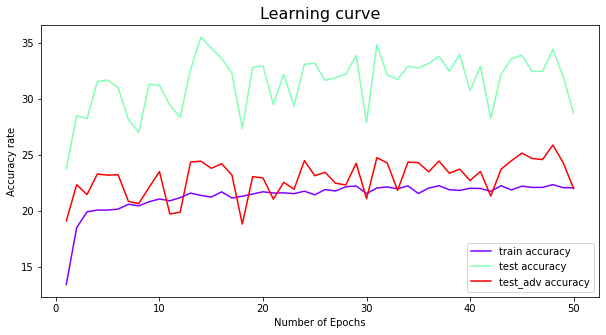

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basicnet_adv_pgdinf.module.save(name=f'basicnet_adv_pgdinf_{epochs}',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# Basic net noise

In [ ]:
# PGDinf
history,basicnetnoise_adv_pgdinf = get_trained_network(BasicNetNoise,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=60, lrthreshold2=80)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 14.282
Final normal test accuracy: 23.87
Final adversarial test Accuracy: 19.14

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 19.128
Final normal test accuracy: 28.16
Final adversarial test Accuracy: 21.4

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 19.472
Final normal test accuracy: 31.41
Final adversarial test Accuracy: 24.34

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 20.072
Final normal test accuracy: 25.78
Final adversarial test Accuracy: 20.03

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 20.756
Final normal test accuracy: 30.38
Final adversarial test Accuracy: 22.96

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 20.65
Final normal test accuracy: 33.14
Final adversarial test Accuracy: 24.54

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 20.902
Final normal test accuracy: 31.49
Final adversarial test Accuracy: 23.47

[ Train

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

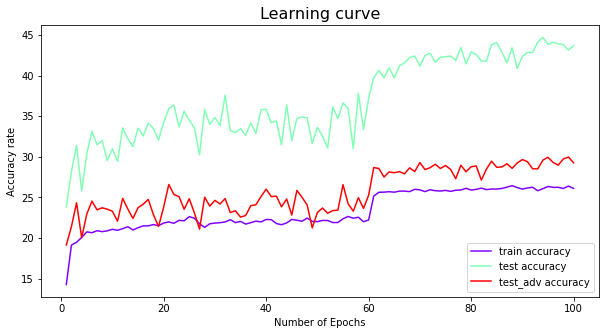

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
basicnetnoise_adv_pgdinf.module.save(name=f'basicnetnoise_adv_pgdinf_{epochs}',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# Resnet with noise

In [ ]:
# Hyperparams

epochs= 50
learning_rate = 0.01
epsilon = 0.03
alpha = 0.0075

In [ ]:
# PGDinf
history,resnet18_adv_pgdinf = get_trained_network(ResNet18,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = PGDinf_attack,load=False,lrthreshold1=25, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 19.814
Final normal test accuracy: 32.5
Final adversarial test Accuracy: 25.12

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 24.686
Final normal test accuracy: 41.55
Final adversarial test Accuracy: 28.77

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 27.25
Final normal test accuracy: 45.46
Final adversarial test Accuracy: 30.51

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 28.89
Final normal test accuracy: 47.5
Final adversarial test Accuracy: 31.55

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 30.652
Final normal test accuracy: 52.58
Final adversarial test Accuracy: 33.17

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 32.19
Final normal test accuracy: 53.27
Final adversarial test Accuracy: 33.56

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 33.524
Final normal test accuracy: 55.61
Final adversarial test Accuracy: 35.2

[ Train epo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

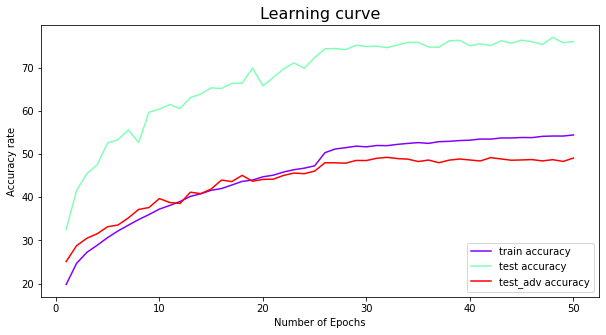

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resnet18_adv_pgdinf.module.save(name='resnet18_adv_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

# Resnet Wider with Noise

In [ ]:
history,resnetwide18_mix_inf = get_trained_network(ResNetWider18,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = 'manual',load=True,lrthreshold1=29, lrthreshold2=33)
#history,resnetwide18_adv_pgd = get_trained_network(ResNetWider18,epochs,epsilon, learning_rate, alpha = alpha,attack = PGDinf_attack, defense = 'manual',load=True,lrthreshold1=29, lrthreshold2=33)

failed

[ Train epoch: 1 ]

Final normal ongoing training accuracy : 20.826
Final normal test accuracy: 38.52
Final adversarial test Accuracy: 26.01

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 25.796
Final normal test accuracy: 41.24
Final adversarial test Accuracy: 28.33

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 28.188
Final normal test accuracy: 44.44
Final adversarial test Accuracy: 31.39

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 30.538
Final normal test accuracy: 49.22
Final adversarial test Accuracy: 31.64

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 32.492
Final normal test accuracy: 54.08
Final adversarial test Accuracy: 33.47

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 33.752
Final normal test accuracy: 55.69
Final adversarial test Accuracy: 35.03

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 35.292
Final normal test accuracy: 57.33
Final adversarial test Accuracy: 38.24

In [ ]:
resnetwide18_mix_inf.module.save(name='resnet18_adv_mix_inf',incolab=incolab,download=True)
#resnetwide18_inf.module.save(name='resnet18_adv_pgd',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

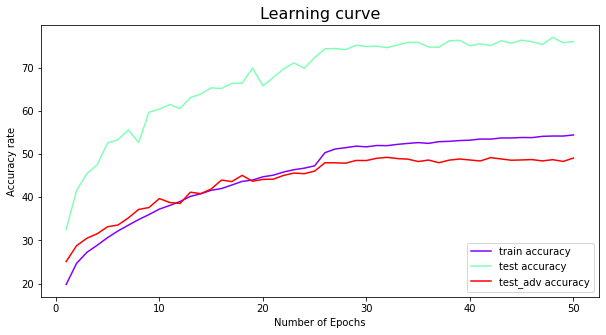

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
resnet18_adv_pgdinf.module.save(name='resnet18_adv_pgdinf',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

Network Randomization

In [ ]:
#without noise
#history,resnet20_advmixed_pgdinf = get_trained_network(Resnet20,epochs,epsilon, learning_rate, trainloader, testloader,
 #                                      alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)



#with noise
history,resnet20_advmixed_pgdinf = get_trained_network(NoiseResnet20,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)

#history,resnet20_advmixed_FGSM = get_trained_network(NoiseResnet20,epochs,epsilon, learning_rate, trainloader, testloader,
#                                       alpha,attack = FGSM_attack, defense = [FGSM_attack,FGSMl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)

Reference_ResNet : Depth : 20 , Layers for each block : 3

[ Train epoch: 1 ]

Final normal ongoing training accuracy : 22.76
Final normal test accuracy: 28.02
Final adversarial test Accuracy: 22.4

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 26.23
Final normal test accuracy: 30.94
Final adversarial test Accuracy: 23.28

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 27.934
Final normal test accuracy: 36.25
Final adversarial test Accuracy: 25.02

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 28.664
Final normal test accuracy: 37.55
Final adversarial test Accuracy: 27.71

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 29.906
Final normal test accuracy: 39.15
Final adversarial test Accuracy: 28.28

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 30.594
Final normal test accuracy: 38.36
Final adversarial test Accuracy: 27.94

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 31.286
Final normal test accura

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

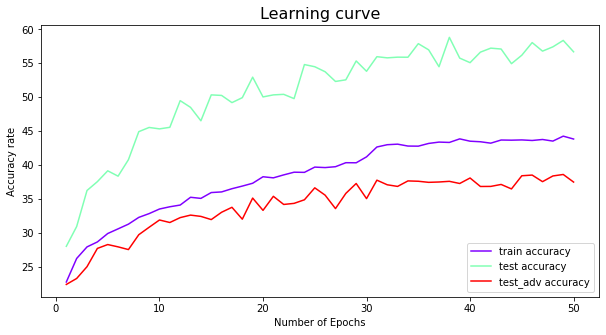

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#history,resnet20_advmixed_FGSM.module.save(name='resnet20_advmixed_FGSM =',incolab=incolab,download=True)

#wide resnet with PGD attack
history,resnet20_advmixed_pgdinf.module.save(name='resnet20_advmixed_pgdinf',incolab=incolab,download=True)
#history,resnet20_advmixed_FGSM.module.save(name='resnet20_advmixed_FGSM =',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

VGG - Big Structure - More capacity

In [21]:
# Hyperparams

epochs= 100
learning_rate = 0.1
epsilon = 0.03
alpha = 0.0075

In [22]:
#epochs = 50
epochs = 100
history,vgg11_mix_inf = get_trained_network(VGGNet11,epochs,epsilon, learning_rate, trainloader, testloader,
                                       alpha,attack = PGDinf_attack, defense = [PGDinf_attack,PGDl2_attack],load=False,lrthreshold1=30, lrthreshold2=40)


[ Train epoch: 1 ]

Final normal ongoing training accuracy : 18.514
Final normal test accuracy: 32.71
Final adversarial test Accuracy: 23.93

[ Train epoch: 2 ]

Final normal ongoing training accuracy : 22.106
Final normal test accuracy: 34.95
Final adversarial test Accuracy: 23.5

[ Train epoch: 3 ]

Final normal ongoing training accuracy : 24.694
Final normal test accuracy: 41.72
Final adversarial test Accuracy: 27.44

[ Train epoch: 4 ]

Final normal ongoing training accuracy : 27.178
Final normal test accuracy: 42.8
Final adversarial test Accuracy: 29.11

[ Train epoch: 5 ]

Final normal ongoing training accuracy : 29.722
Final normal test accuracy: 45.1
Final adversarial test Accuracy: 30.72

[ Train epoch: 6 ]

Final normal ongoing training accuracy : 31.136
Final normal test accuracy: 52.16
Final adversarial test Accuracy: 30.68

[ Train epoch: 7 ]

Final normal ongoing training accuracy : 32.66
Final normal test accuracy: 52.75
Final adversarial test Accuracy: 34.31

[ Train e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

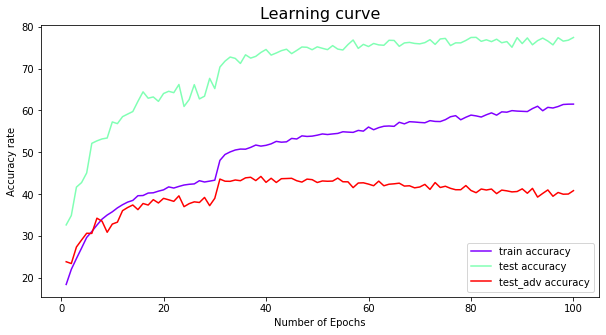

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
history,vgg11_mix_inf.module.save(name='vgg11_mix_inf_50',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

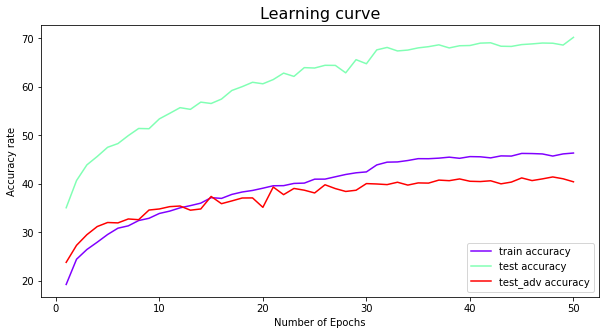

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history,vgg11_mix_inf.module.save(name='vgg11_mix_inf_50',incolab=incolab,download=True)
plot_history(history,incolab=incolab,download=True)
save_history(history,incolab=incolab,download=True)